<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/FFN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [19]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
print(type(data))

# extract labels and drop labels from data:
labels = data[:,0] # extract
data   = data[:,1:] # drop

<class 'numpy.ndarray'>


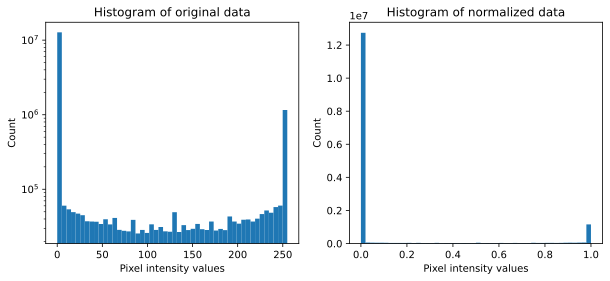

In [20]:
# normalization (scale down from [0, 255] to [0 1]):
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log') # (optional) increase sensitivity

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

👆Interpretation:

---

*   Most pixels are black (intensity = 0).
*   And only a small count of pixels are white (intensity = 255).


In [21]:
# Workflow: numpy array -> pytorch tensor ->  pytorch TensorDataset obj -> pytorch DataLoader obj

# Step 1: numpy array -> pytorch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64 (64-bit int)

# Step 2: split data using scikitlearn
# data tensor -> train_data,test_data
# labels tensor -> train_labels,test_labels
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1) # still tensors
print(train_data.shape,test_data.shape, train_labels.shape,test_labels.shape)

# Step 3: pytorch tensors -> pytorch TensorDataset objects
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: pytorch TensorDataset objects -> pytorch dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([2000, 784]) torch.Size([18000]) torch.Size([2000])


In [22]:
# check all variables in workspace:
%whos # (Jupyter Notebook command) display a list of variables in the current namespace

No variables match your requested type.


In [23]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layers: fully connected networks
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NOTE: apply log-softmax to the output layer, b/c we will use NLLLoss (negative log likelihood loss) instead of CrossEntropyLoss as the loss function

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss() # NLLLoss (Negative Log Likelihood Loss)

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01) # try Adam or RMSprop over SGD!

  return net,lossfun,optimizer

In [24]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

# Extract a single mini-batch of data from the `train_loader` object:
# 1. create an iterator from the train_loader object
# 2. obtain the next item from the iterator
# 3. store the data and corresponding labels respectively
X,y = next(iter(train_loader))
yHat = net(X)
# print(yHat.shape) # torch.Size([32, 10])

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3008, grad_fn=<NllLossBackward0>)


In [25]:
# a function that trains the model

def function2trainTheModel():

  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output:
  return trainAcc,testAcc,losses,net

In [26]:
trainAcc,testAcc,losses,net = function2trainTheModel()

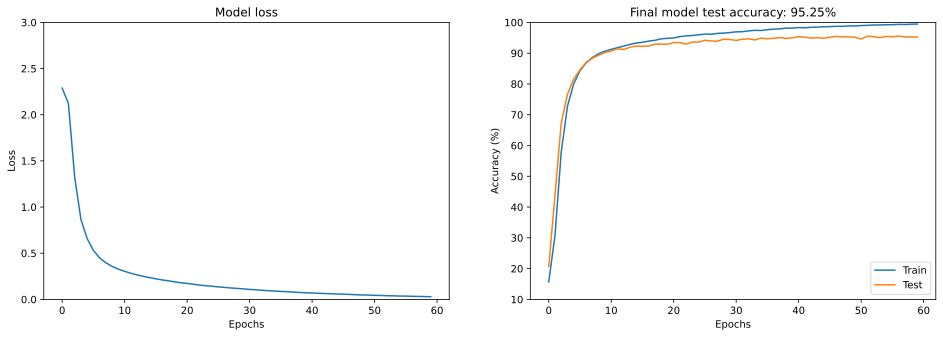

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail:

In [30]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

print(predictions)
print(torch.exp(predictions))

tensor([[-8.9498e-04, -2.7900e+01, -8.1955e+00,  ..., -1.1985e+01,
         -1.1695e+01, -7.7394e+00],
        [-1.6117e+01, -1.8018e+01, -1.4330e+01,  ..., -1.4484e+01,
         -1.3320e+01, -5.0594e+00],
        [-2.2114e+01, -2.6163e+01, -2.3943e+01,  ..., -1.3801e+01,
         -1.3124e+01, -1.5020e-05],
        ...,
        [-1.5744e+01, -1.4652e+01, -1.3111e+01,  ..., -1.5928e+01,
         -1.3070e+01, -2.4181e+01],
        [-2.9374e+01, -1.0048e-01, -1.1945e+01,  ..., -1.5697e+01,
         -1.2364e+01, -2.1467e+01],
        [-2.2905e+01, -1.6989e+01, -2.3465e+01,  ..., -1.4907e+01,
         -9.8792e+00, -3.6897e+00]])
tensor([[9.9911e-01, 7.6393e-13, 2.7589e-04,  ..., 6.2389e-06, 8.3377e-06,
         4.3533e-04],
        [1.0007e-07, 1.4963e-08, 5.9801e-07,  ..., 5.1253e-07, 1.6409e-06,
         6.3496e-03],
        [2.4881e-10, 4.3400e-12, 3.9955e-11,  ..., 1.0144e-06, 1.9974e-06,
         9.9998e-01],
        ...,
        [1.4543e-07, 4.3337e-07, 2.0220e-06,  ..., 1.2095e-07, 2

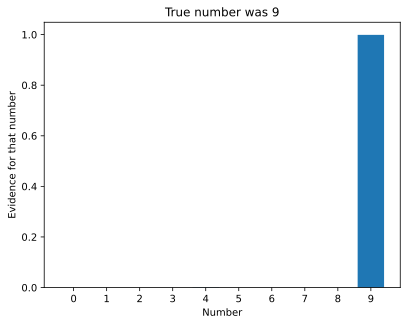

In [32]:
# Evidence for all numbers from one sample
sample2show = 120

# plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.bar(range(10),torch.exp(predictions[sample2show])) # less sensitive for small possibilities
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  20   37   38   57   81   85   90  130  183  185  186  191  202  249
  252  256  279  351  353  357  363  370  373  375  390  391  425  447
  467  494  548  549  582  593  616  635  642  667  701  778  810  849
  869  878  890  894  930  943  968 1006 1022 1042 1046 1056 1068 1094
 1125 1141 1197 1214 1263 1278 1310 1373 1435 1450 1473 1476 1478 1487
 1530 1573 1583 1604 1609 1620 1632 1647 1674 1680 1688 1690 1745 1784
 1794 1796 1806 1864 1872 1906 1934 1935 1967 1986 1998]


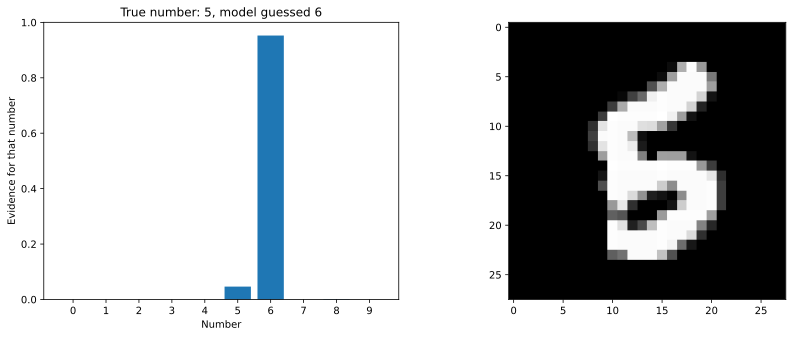

In [37]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0] # find indices for all mis-matches
print(errors)

# pick the 4th mis-match for demo:
sample2show = 4

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()